In [62]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score as CVS, train_test_split
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import datetime
import lightgbm as lgb
from lightgbm import LGBMClassifier
from collections import Counter
import gc

In [81]:
accident=pd.read_csv('D:/Thesis/UK/UK/UK_2015-2019_with-nan.csv',index_col=0,dtype={'Accident_Index': 'str'})
pd.set_option('display.max_columns', 1000)

In [82]:
accident

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Year,Month,Day,Day_of_year,Hour,Minute_of_day
0,201597UA71710,2,1,1,2.0,75.0,10.0,3,0.0,0.0,0.0,0.0,9.0,3.0,NaN,-4.642617,55.646895,3,2,1,2015-10-27,3,13:00:00,4,785,6.0,60.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,9.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,2.0,75.0,10.0,1992.0,2.0,7.0,NaN,3.0,NaN,2015,10,27,300,13,780.0
1,201597UA71810,2,1,2,2.0,63.0,9.0,2,0.0,0.0,0.0,4.0,11.0,3.0,NaN,-4.864141,55.731777,2,3,10,2015-10-31,7,10:00:00,3,78,6.0,60.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,11.0,0.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,60.0,9.0,6871.0,2.0,7.0,NaN,3.0,NaN,2015,10,31,304,10,600.0
2,201597UA71810,2,2,2,2.0,75.0,10.0,2,0.0,0.0,0.0,4.0,11.0,1.0,NaN,-4.864141,55.731777,2,3,10,2015-10-31,7,10:00:00,3,78,6.0,60.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,11.0,0.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,60.0,9.0,6871.0,2.0,7.0,NaN,3.0,NaN,2015,10,31,304,10,600.0
3,201597UA71810,2,3,2,1.0,78.0,11.0,2,0.0,0.0,0.0,4.0,11.0,1.0,NaN,-4.864141,55.731777,2,3,10,2015-10-31,7,10:00:00,3,78,6.0,60.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,11.0,0.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,60.0,9.0,6871.0,2.0,7.0,NaN,3.0,NaN,2015,10,31,304,10,600.0
4,201597UA71810,2,4,2,1.0,67.0,10.0,2,0.0,0.0,0.0,4.0,11.0,1.0,NaN,-4.864141,55.731777,2,3,10,2015-10-31,7,10:00:00,3,78,6.0,60.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,11.0,0.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,60.0,9.0,6871.0,2.0,7.0,NaN,3.0,NaN,2015,10,31,304,10,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832453,2019984106919,1,1,1,1.0,24.0,5.0,3,0.0,0.0,0.0,0.0,19.0,3.0,6.0,-3.368899,55.047323,3,1,1,2019-05-18,7,01:00:00,4,725,6.0,60.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,19.0,0.0,17.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,24.0,5.0,1997.0,2.0,14.0,6.0,3.0,6.0,2019,5,18,138,1,60.0
832454,2019984107019,1,1,1,1.0,22.0,5.0,3,0.0,0.0,0.0,0.0,19.0,1.0,1.0,-2.983499,55.215407,3,4,1,2019-05-30,5,08:46:00,3,7,6.0,60.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,19.0,4.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,22.0,5.0,2143.0,2.0,1.0,1.0,1.0,1.0,2019,5,30,150,8,526.0
832455,2019984107219,2,1,1,1.0,61.0,9.0,3,0.0,0.0,0.0,0.0,9.0,3.0,7.0,-3.274645,54.991685,3,2,1,2019-06-21,6,15:30:00,4,723,6.0,60.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,9.0,0.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,61.0,9.0,2967.0,2.0,5.0,7.0,3.0,7.0,2019,6,21,172,15,930.0
832456,2019984107419,1,1,3,1.0,54.0,8.0,3,5.0,3.0,0.0,0.0,0.0,3.0,8.0,-2.997491,55.148292,3,1,1,2019-06-29,7,14:10:00,6,710,6.0,30.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,9.0,0.0,7.0,0.0,6.0,0.0,0.0,3.0,0.0,3.0,1.0,5.0,1.0,78.0,11.0,1597.0,2.0,6.0,8.0,3.0,8.0,2019,6,29,180,14,850.0


In [83]:
Counter(accident.Casualty_Severity)

Counter({3: 702265, 2: 121366, 1: 8827})

In [84]:
accident.drop(['Vehicle_Reference','Casualty_Reference','Longitude','Latitude','Date','Time','1st_Road_Number','Accident_Index','Day_of_year','Minute_of_day','Did_Police_Officer_Attend_Scene_of_Accident',],inplace=True,axis=1)

#severe or slight
accident['Serious_Fatal'] = 0
accident.loc[accident['Casualty_Severity'] < 3, 'Serious_Fatal'] = 1
print(accident['Serious_Fatal'].value_counts())

#fatal or not
accident['Fatal'] = 0
accident.loc[accident['Casualty_Severity'] == 1, 'Fatal'] = 1
print(accident['Fatal'].value_counts())

0    702265
1    130193
Name: Serious_Fatal, dtype: int64
0    823631
1      8827
Name: Fatal, dtype: int64


In [85]:
accident=accident.drop(['Casualty_Severity','Accident_Severity'],axis=1)

In [91]:
accident

,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Year,Month,Day,Hour,Serious_Fatal,Fatal
0,1,2.0,75.0,10.0,0.0,0.0,0.0,0.0,9.0,3.0,NaN,2,1,3,4,6.0,60.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,9.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,2.0,75.0,10.0,1992.0,2.0,7.0,NaN,3.0,NaN,2015,10,27,13,0,0
1,2,2.0,63.0,9.0,0.0,0.0,0.0,4.0,11.0,3.0,NaN,3,10,7,3,6.0,60.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,11.0,0.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,60.0,9.0,6871.0,2.0,7.0,NaN,3.0,NaN,2015,10,31,10,1,0
2,2,2.0,75.0,10.0,0.0,0.0,0.0,4.0,11.0,1.0,NaN,3,10,7,3,6.0,60.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,11.0,0.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,60.0,9.0,6871.0,2.0,7.0,NaN,3.0,NaN,2015,10,31,10,1,0
3,2,1.0,78.0,11.0,0.0,0.0,0.0,4.0,11.0,1.0,NaN,3,10,7,3,6.0,60.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,11.0,0.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,60.0,9.0,6871.0,2.0,7.0,NaN,3.0,NaN,2015,10,31,10,1,0
4,2,1.0,67.0,10.0,0.0,0.0,0.0,4.0,11.0,1.0,NaN,3,10,7,3,6.0,60.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,11.0,0.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,60.0,9.0,6871.0,2.0,7.0,NaN,3.0,NaN,2015,10,31,10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832453,1,1.0,24.0,5.0,0.0,0.0,0.0,0.0,19.0,3.0,6.0,1,1,7,4,6.0,60.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,19.0,0.0,17.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,24.0,5.0,1997.0,2.0,14.0,6.0,3.0,6.0,2019,5,18,1,0,0
832454,1,1.0,22.0,5.0,0.0,0.0,0.0,0.0,19.0,1.0,1.0,4,1,5,3,6.0,60.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,19.0,4.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,22.0,5.0,2143.0,2.0,1.0,1.0,1.0,1.0,2019,5,30,8,0,0
832455,1,1.0,61.0,9.0,0.0,0.0,0.0,0.0,9.0,3.0,7.0,2,1,6,4,6.0,60.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,9.0,0.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,61.0,9.0,2967.0,2.0,5.0,7.0,3.0,7.0,2019,6,21,15,0,0
832456,3,1.0,54.0,8.0,5.0,3.0,0.0,0.0,0.0,3.0,8.0,1,1,7,6,6.0,30.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,9.0,0.0,7.0,0.0,6.0,0.0,0.0,3.0,0.0,3.0,1.0,5.0,1.0,78.0,11.0,1597.0,2.0,6.0,8.0,3.0,8.0,2019,6,29,14,0,0


In [126]:
train_set, test_set = train_test_split(accident, test_size=0.3, random_state=710)

In [87]:
print(train_set.shape,test_set.shape)

(582720, 51) (249738, 51)


In [127]:
train_severe=train_set[train_set['Serious_Fatal']==1]
train_slight=train_set[train_set['Serious_Fatal']==0]
train_fatal=train_set[train_set['Fatal']==1]
train_alive=train_set[train_set['Fatal']==0]
X_train=train_set.drop(['Serious_Fatal','Fatal'],axis=1)
y_train=train_set['Serious_Fatal']
X_test=test_set.drop(['Serious_Fatal','Fatal'],axis=1)
y_test=test_set['Serious_Fatal']

In [89]:
train_severe.shape

(91112, 51)

In [90]:
train_slight.shape

(491608, 51)

# Undersample

In [92]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)

In [93]:
#Speed_limit,Age(two kinds), Engine_Capacity_(CC),Age_of_Vehicle
categorical_feature = ['Casualty_Class','Sex_of_Casualty','Age_Band_of_Casualty','Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger',
       'Bus_or_Coach_Passenger', 'Casualty_Type', 'Casualty_Home_Area_Type','Casualty_IMD_Decile','Number_of_Vehicles', 
       'Day_of_Week','1st_Road_Class', 'Road_Type', 'Junction_Detail','Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards','Urban_or_Rural_Area', 'Vehicle_Type', 
       'Towing_and_Articulation', 'Vehicle_Manoeuvre','Vehicle_Location-Restricted_Lane', 'Junction_Location','Skidding_and_Overturning', 
       'Hit_Object_in_Carriageway','Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway','1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_Band_of_Driver', 'Propulsion_Code',
       'Driver_IMD_Decile', 'Driver_Home_Area_Type','Vehicle_IMD_Decile', 'Year', 'Month', 'Day', 'Hour',
        #'Day_of_year', 'Minute_of_day','Did_Police_Officer_Attend_Scene_of_Accident',
        ]

lgb_train = lgb.Dataset(X_undersampled, y_undersampled,categorical_feature= categorical_feature)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train,categorical_feature= categorical_feature)

# 参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'binary',  # 目标函数 'binary'  'cross_entropy'
    'metric': 'auc',  # 评估函数['l2', 'auc','binary_logloss']
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.01,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    'bagging_fraction': 0.8,  # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1,  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
#    'scale_pos_weight':10,
#     'is_unbalance': 'true',   
}# 385494/80545   80545/385494

# 模型训练
gbm = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=lgb_eval, early_stopping_rounds=5)

# 模型预测
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_train=gbm.predict(X_undersampled, num_iteration=gbm.best_iteration)

# # 模型评估
# print('The rmse of prediction is:', MSE(y_test, y_pred) ** 0.5)
# print('The rmse of train_X prediction is:', MSE(y_train, y_pred_train) ** 0.5)

C:\Users\admin\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 91112, number of negative: 91112
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 984
[LightGBM] [Info] Number of data points in the train set: 182224, number of used features: 49


C:\Users\admin\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\admin\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[1]	valid_0's auc: 0.738551
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.740433
[3]	valid_0's auc: 0.741914
[4]	valid_0's auc: 0.742191
[5]	valid_0's auc: 0.742879
[6]	valid_0's auc: 0.744241
[7]	valid_0's auc: 0.744806
[8]	valid_0's auc: 0.746293
[9]	valid_0's auc: 0.746405
[10]	valid_0's auc: 0.74648
[11]	valid_0's auc: 0.74718
[12]	valid_0's auc: 0.747366
[13]	valid_0's auc: 0.7484
[14]	valid_0's auc: 0.748479
[15]	valid_0's auc: 0.748569
[16]	valid_0's auc: 0.74872
[17]	valid_0's auc: 0.748632
[18]	valid_0's auc: 0.748806
[19]	valid_0's auc: 0.749103
[20]	valid_0's auc: 0.749533
[21]	valid_0's auc: 0.749631
[22]	valid_0's auc: 0.749717
[23]	valid_0's auc: 0.749747
[24]	valid_0's auc: 0.749852
[25]	valid_0's auc: 0.749886
[26]	valid_0's auc: 0.749912
[27]	valid_0's auc: 0.74994
[28]	valid_0's auc: 0.749981
[29]	valid_0's auc: 0.750575
[30]	valid_0's auc: 0.750727
[31]	v

In [94]:
def plot_report_and_matrix(threshold=0.5,y_pred=y_pred, y_real=y_test):
    # threshold
    y_pred_bi=y_pred.copy()
    threshold=0.5
    y_pred_bi[y_pred>threshold]=1
    y_pred_bi[y_pred_bi!=1]=0

    from sklearn import metrics
    print(metrics.classification_report(y_real,y_pred_bi))


    from sklearn.metrics import multilabel_confusion_matrix
    sns.set(font_scale = 1)
    confmat = multilabel_confusion_matrix(y_true=y_real, y_pred=y_pred_bi,
                           labels=[1])

    conf_matrix = pd.DataFrame(data=confmat[0],
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    plt.figure(figsize = (8,5))
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu").set_title(
    "Confusion Matrix\n-Default LightGBM", fontsize=16)
    plt.show()

              precision    recall  f1-score   support

           0       0.93      0.64      0.76    210657
           1       0.28      0.76      0.41     39081

    accuracy                           0.66    249738
   macro avg       0.61      0.70      0.59    249738
weighted avg       0.83      0.66      0.71    249738



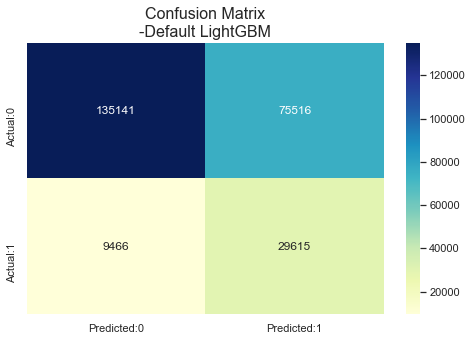

In [95]:
plot_report_and_matrix()

              precision    recall  f1-score   support

           0       0.74      0.66      0.70     91112
           1       0.69      0.77      0.73     91112

    accuracy                           0.71    182224
   macro avg       0.72      0.71      0.71    182224
weighted avg       0.72      0.71      0.71    182224



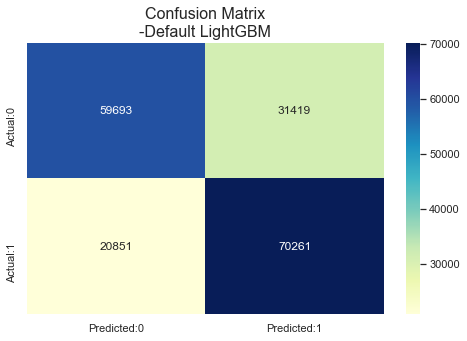

In [97]:
plot_report_and_matrix(y_pred=y_pred_train,y_real=y_undersampled)

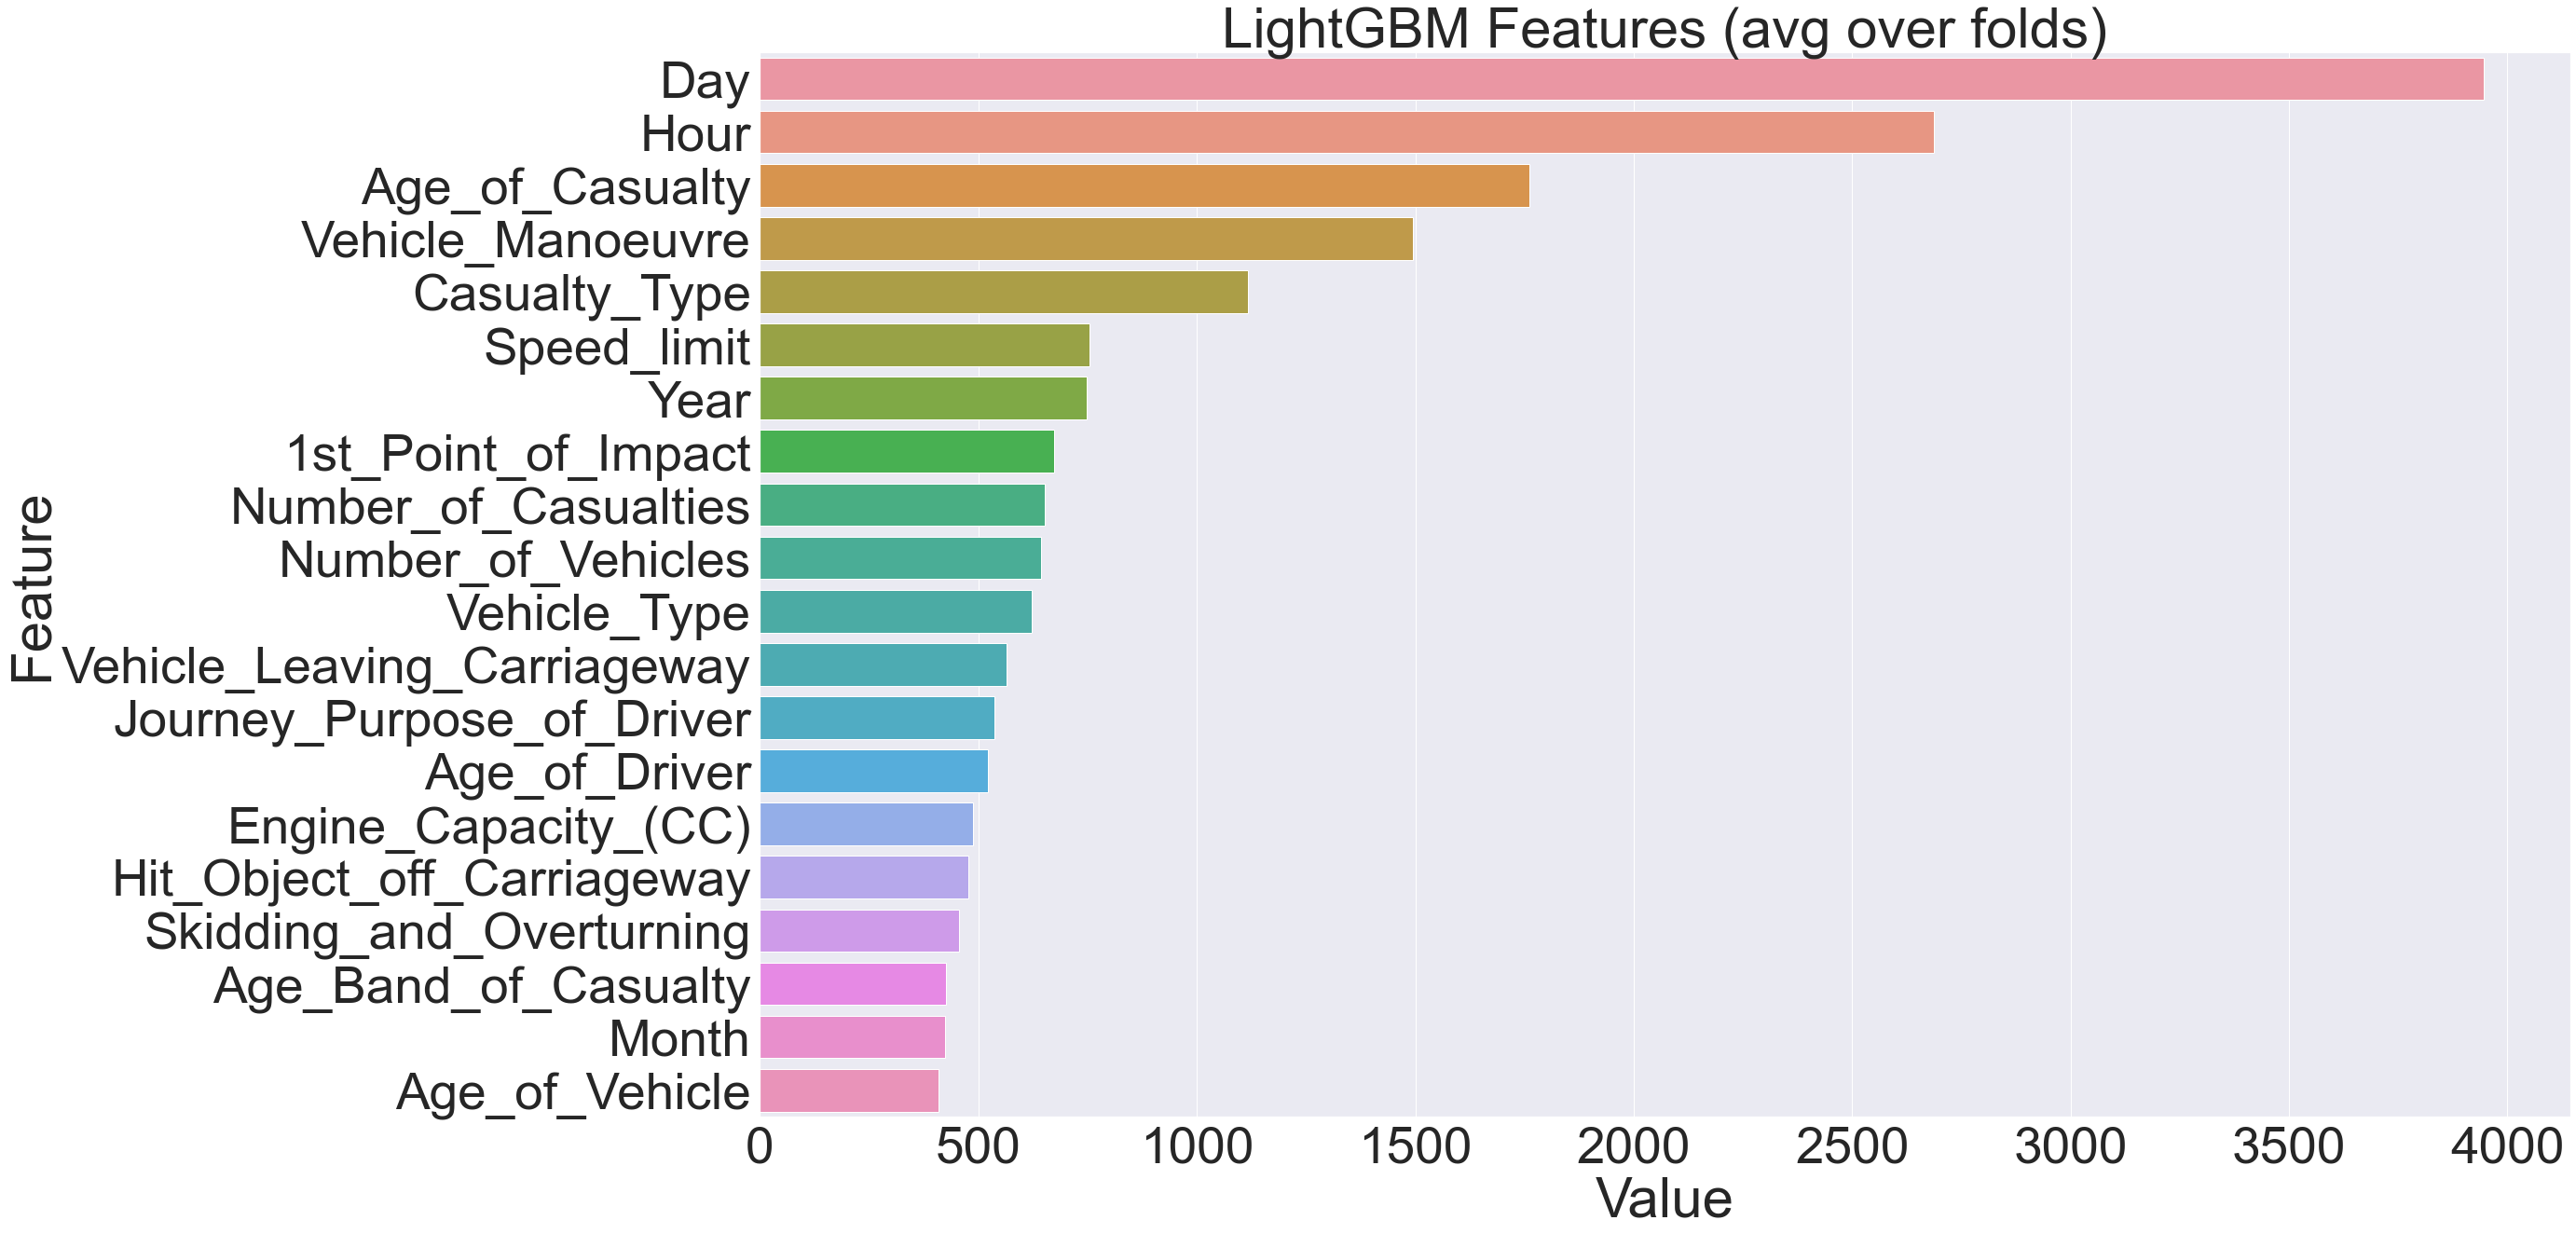

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
plotImp(gbm, X=X_train , num = 20)

# oversample

## random oversample

In [101]:
from imblearn.over_sampling import RandomOverSampler
 
ros = RandomOverSampler(random_state=0)
X_random_oversampled, y_random_oversampled = ros.fit_sample(X_train, y_train)


In [102]:
#Speed_limit,Age(two kinds), Engine_Capacity_(CC),Age_of_Vehicle
categorical_feature = ['Sex_of_Casualty','Age_Band_of_Casualty','Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger',
       'Bus_or_Coach_Passenger', 'Casualty_Type', 'Casualty_Home_Area_Type','Casualty_IMD_Decile','Number_of_Vehicles', 
       'Day_of_Week','1st_Road_Class', 'Road_Type', 'Junction_Detail','Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards','Urban_or_Rural_Area', 'Vehicle_Type', 
       'Towing_and_Articulation', 'Vehicle_Manoeuvre','Vehicle_Location-Restricted_Lane', 'Junction_Location','Skidding_and_Overturning', 
       'Hit_Object_in_Carriageway','Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway','1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_Band_of_Driver', 'Propulsion_Code',
       'Driver_IMD_Decile', 'Driver_Home_Area_Type','Vehicle_IMD_Decile', 'Year', 'Month', 'Day', 'Hour',
        #'Day_of_year', 'Minute_of_day','Did_Police_Officer_Attend_Scene_of_Accident',
        ]

lgb_train = lgb.Dataset(X_random_oversampled, y_random_oversampled,categorical_feature= categorical_feature)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train,categorical_feature= categorical_feature)

# 参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'binary',  # 目标函数 'binary'  'cross_entropy'
    'metric': 'auc',  # 评估函数['l2', 'auc','binary_logloss']
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.01,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    'bagging_fraction': 0.8,  # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1,  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
#    'scale_pos_weight':10,
#     'is_unbalance': 'true',   
}# 385494/80545   80545/385494

# 模型训练
gbm = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets=lgb_eval, early_stopping_rounds=5)

# 模型预测
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_train=gbm.predict(X_train, num_iteration=gbm.best_iteration)

C:\Users\admin\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 491608, number of negative: 491608
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 983216, number of used features: 49


C:\Users\admin\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\admin\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[1]	valid_0's auc: 0.739806
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.741933
[3]	valid_0's auc: 0.742474
[4]	valid_0's auc: 0.743252
[5]	valid_0's auc: 0.743254
[6]	valid_0's auc: 0.743966
[7]	valid_0's auc: 0.743931
[8]	valid_0's auc: 0.7447
[9]	valid_0's auc: 0.745249
[10]	valid_0's auc: 0.745117
[11]	valid_0's auc: 0.746399
[12]	valid_0's auc: 0.746666
[13]	valid_0's auc: 0.74787
[14]	valid_0's auc: 0.748033
[15]	valid_0's auc: 0.747949
[16]	valid_0's auc: 0.748331
[17]	valid_0's auc: 0.74846
[18]	valid_0's auc: 0.748911
[19]	valid_0's auc: 0.748988
[20]	valid_0's auc: 0.749209
[21]	valid_0's auc: 0.749173
[22]	valid_0's auc: 0.749334
[23]	valid_0's auc: 0.749417
[24]	valid_0's auc: 0.749436
[25]	valid_0's auc: 0.749605
[26]	valid_0's auc: 0.749787
[27]	valid_0's auc: 0.749728
[28]	valid_0's auc: 0.749768
[29]	valid_0's auc: 0.750456
[30]	valid_0's auc: 0.750517
[31]

              precision    recall  f1-score   support

           0       0.93      0.64      0.76    210657
           1       0.28      0.76      0.41     39081

    accuracy                           0.66    249738
   macro avg       0.61      0.70      0.59    249738
weighted avg       0.83      0.66      0.71    249738



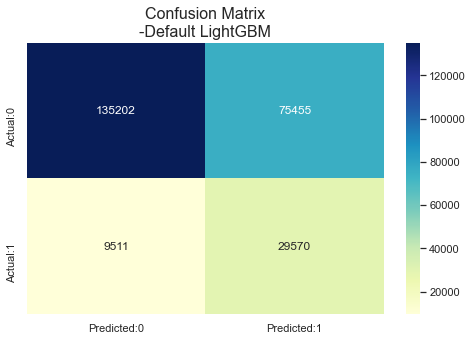

In [103]:
plot_report_and_matrix()

              precision    recall  f1-score   support

           0       0.94      0.66      0.77    491608
           1       0.29      0.77      0.43     91112

    accuracy                           0.68    582720
   macro avg       0.62      0.71      0.60    582720
weighted avg       0.84      0.68      0.72    582720



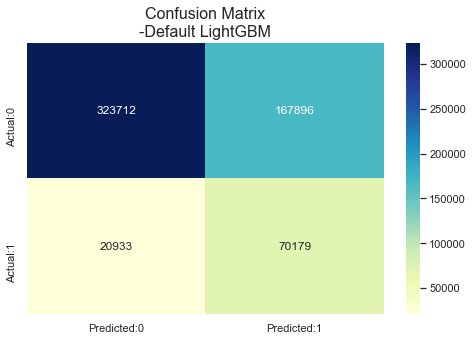

In [104]:
plot_report_and_matrix(y_pred=y_pred_train,y_real=y_train)

## Smote+onehot

In [47]:
accident_onehot=pd.read_csv('D:/Thesis/UK/UK/UK_2015-2019_one-hot.csv',index_col=0,dtype='int16')

In [48]:
accident_onehot

,Age_of_Casualty,Casualty_Severity,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Speed_limit,Age_of_Driver,Engine_Capacity_(CC),Age_of_Vehicle,Age_of_Driver_Na,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,75,3,3,2,1,60,75,1992,7,0,...,0,0,0,0,0,0,0,0,0,0
1,63,2,2,3,10,60,60,6871,7,0,...,0,0,0,0,0,0,0,0,0,0
2,75,2,2,3,10,60,60,6871,7,0,...,0,0,0,0,0,0,0,0,0,0
3,78,2,2,3,10,60,60,6871,7,0,...,0,0,0,0,0,0,0,0,0,0
4,67,2,2,3,10,60,60,6871,7,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-19515,24,3,3,1,1,60,24,1997,14,0,...,0,0,0,0,0,0,0,0,0,0
-19514,22,3,3,4,1,60,22,2143,1,0,...,0,0,0,0,0,0,0,0,0,0
-19513,61,3,3,2,1,60,61,2967,5,0,...,0,1,0,0,0,0,0,0,0,0
-19512,54,3,3,1,1,30,78,1597,6,0,...,1,0,0,0,0,0,0,0,0,0


In [49]:

#severe or slight
accident_onehot['Serious_Fatal'] = 0
accident_onehot.loc[accident_onehot['Casualty_Severity'] < 3, 'Serious_Fatal'] = 1
print(accident_onehot['Serious_Fatal'].value_counts())

#fatal or not
accident_onehot['Fatal'] = 0
accident_onehot.loc[accident_onehot['Casualty_Severity'] == 1, 'Fatal'] = 1
print(accident_onehot['Fatal'].value_counts())

accident_onehot=accident_onehot.drop(['Casualty_Severity','Accident_Severity'],axis=1)

0    702265
1    130193
Name: Serious_Fatal, dtype: int64
0    823631
1      8827
Name: Fatal, dtype: int64


In [50]:
train_set, test_set = train_test_split(accident_onehot, test_size=0.3, random_state=710)

In [51]:
train_severe=train_set[train_set['Serious_Fatal']==1]
train_slight=train_set[train_set['Serious_Fatal']==0]
train_fatal=train_set[train_set['Fatal']==1]
train_alive=train_set[train_set['Fatal']==0]
X_train=train_set.drop(['Serious_Fatal','Fatal'],axis=1)
y_train=train_set['Serious_Fatal']
X_test=test_set.drop(['Serious_Fatal','Fatal'],axis=1)
y_test=test_set['Serious_Fatal']

In [52]:
gc.collect()

23767

In [53]:
from imblearn.over_sampling import SMOTE
 
X_resampled_smote, y_resampled_smote = SMOTE(random_state=0).fit_sample(X_train, y_train)


In [59]:

lgb_train = lgb.Dataset(X_resampled_smote, y_resampled_smote)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# 参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'binary',  # 目标函数 'binary'  'cross_entropy'
    'metric': 'auc',  # 评估函数['l2', 'auc','binary_logloss']
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.01,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    'bagging_fraction': 0.8,  # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1,  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
#    'scale_pos_weight':10,
#     'is_unbalance': 'true',   
}# 385494/80545   80545/385494

# 模型训练
gbm = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets=lgb_eval, early_stopping_rounds=5)

# 模型预测
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_train=gbm.predict(X_resampled_smote, num_iteration=gbm.best_iteration)

[LightGBM] [Info] Number of positive: 491608, number of negative: 491608
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.378759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1421
[LightGBM] [Info] Number of data points in the train set: 983216, number of used features: 404
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[1]	valid_0's auc: 0.694546
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.701596
[3]	valid_0's auc: 0.704658
[4]	valid_0's auc: 0.712183
[5]	valid_0's auc: 0.710215
[6]	valid_0's auc: 0.710386
[7]	valid_0's auc: 0.709801
[8]	valid_0's auc: 0.711506
[9]	valid_0's auc: 0.711689
Early stopping, best iteration is:
[4]	valid_0's auc: 0.712183


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    210657
           1       1.00      1.00      1.00     39081

    accuracy                           1.00    249738
   macro avg       1.00      1.00      1.00    249738
weighted avg       1.00      1.00      1.00    249738



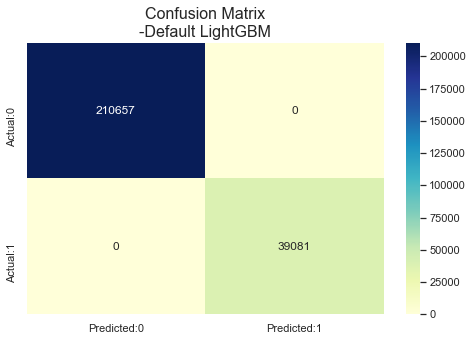

In [60]:
plot_report_and_matrix()

              precision    recall  f1-score   support

           0       0.78      0.92      0.84    491608
           1       0.90      0.75      0.82    491608

    accuracy                           0.83    983216
   macro avg       0.84      0.83      0.83    983216
weighted avg       0.84      0.83      0.83    983216



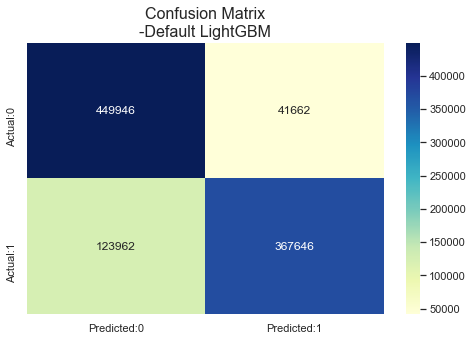

In [61]:
plot_report_and_matrix(y_pred=y_pred_train,y_real=y_resampled_smote)

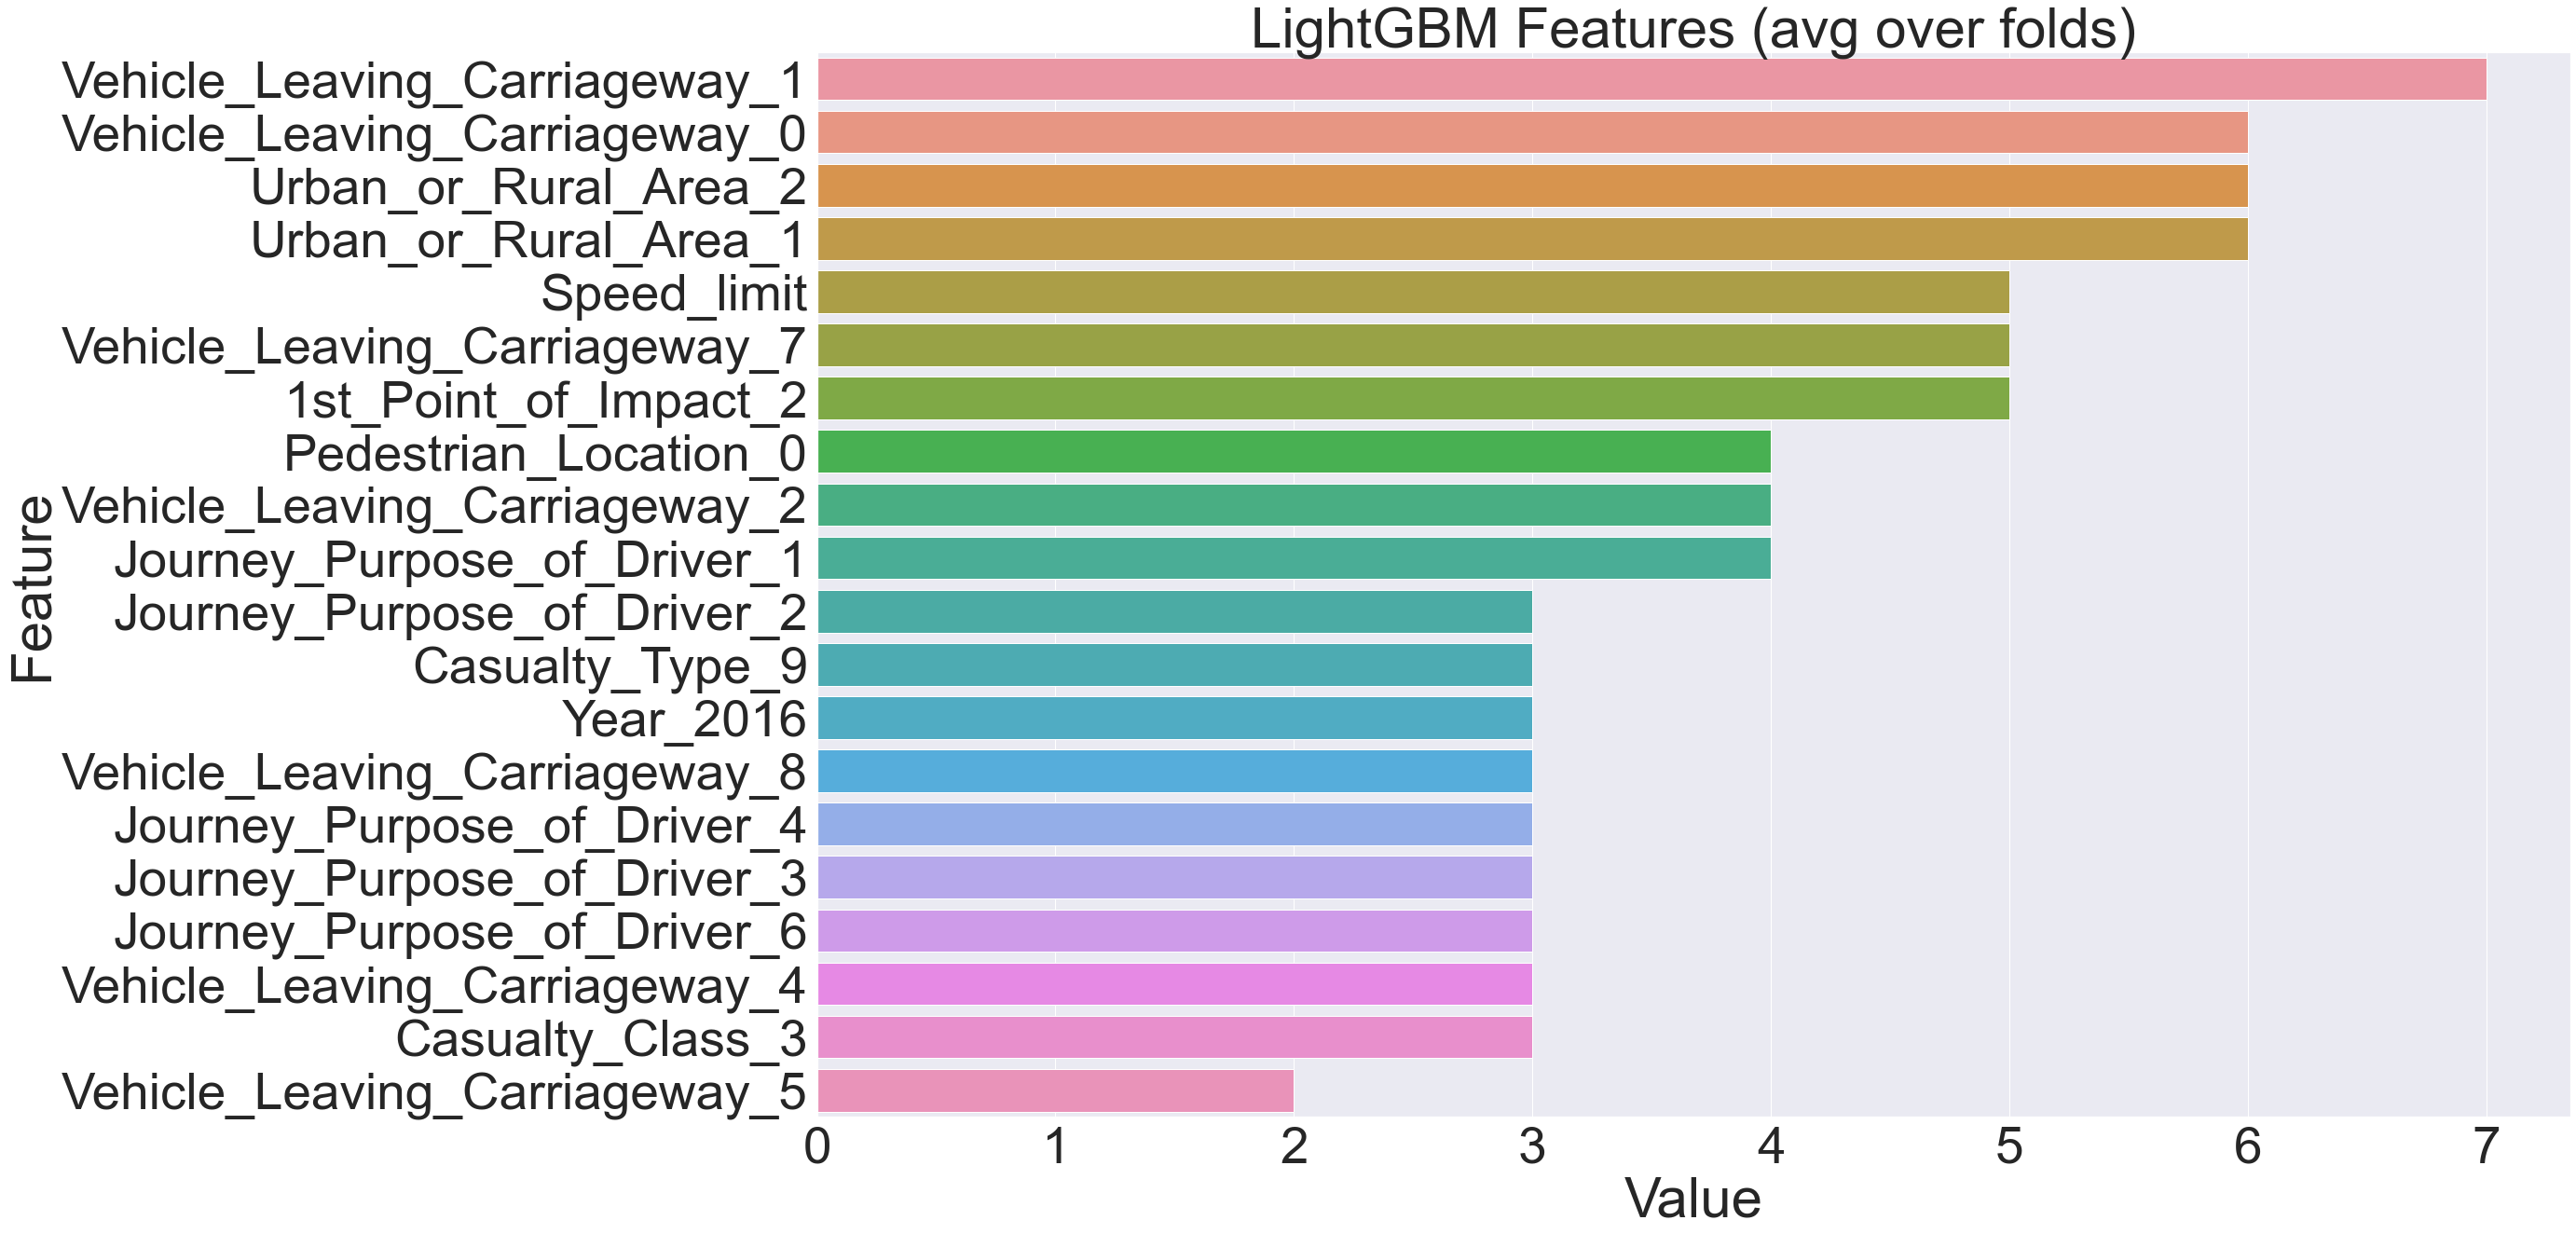

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
plotImp(gbm, X=X_train , num = 20)

In [ ]:
from imblearn.over_sampling import ADASYN

X_resampled_adasyn, y_resampled_adasyn = ADASYN(random_state=0).fit_sample(X_train, y_train)

# easy emsamble

In [102]:
train_severe.shape

(91112, 51)

In [100]:
train_slight.shape

(491608, 51)

In [108]:
train_slight_1=train_slight.iloc[:100000,:]
train_slight_2=train_slight.iloc[100001:200000,:]
train_slight_3=train_slight.iloc[200001:300000,:]
train_slight_4=train_slight.iloc[300001:400000,:]
train_slight_5=train_slight.iloc[400001:491607,:]

train_1=pd.concat([train_severe,train_slight_1])
X_train_1=train_1.drop(['Serious_Fatal','Fatal'],axis=1)
y_train_1=train_1['Serious_Fatal']

train_2=pd.concat([train_severe,train_slight_2])
X_train_2=train_2.drop(['Serious_Fatal','Fatal'],axis=1)
y_train_2=train_2['Serious_Fatal']

train_3=pd.concat([train_severe,train_slight_3])
X_train_3=train_3.drop(['Serious_Fatal','Fatal'],axis=1)
y_train_3=train_3['Serious_Fatal']

train_4=pd.concat([train_severe,train_slight_4])
X_train_4=train_4.drop(['Serious_Fatal','Fatal'],axis=1)
y_train_4=train_4['Serious_Fatal']

train_5=pd.concat([train_severe,train_slight_5])
X_train_5=train_5.drop(['Serious_Fatal','Fatal'],axis=1)
y_train_5=train_5['Serious_Fatal']

In [114]:
categorical_feature = ['Casualty_Class','Sex_of_Casualty','Age_Band_of_Casualty','Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger',
       'Bus_or_Coach_Passenger', 'Casualty_Type', 'Casualty_Home_Area_Type','Casualty_IMD_Decile','Number_of_Vehicles', 
       'Day_of_Week','1st_Road_Class', 'Road_Type', 'Junction_Detail','Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards','Urban_or_Rural_Area', 'Vehicle_Type', 
       'Towing_and_Articulation', 'Vehicle_Manoeuvre','Vehicle_Location-Restricted_Lane', 'Junction_Location','Skidding_and_Overturning', 
       'Hit_Object_in_Carriageway','Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway','1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_Band_of_Driver', 'Propulsion_Code',
       'Driver_IMD_Decile', 'Driver_Home_Area_Type','Vehicle_IMD_Decile', 'Year', 'Month', 'Day', 'Hour',
        #'Day_of_year', 'Minute_of_day','Did_Police_Officer_Attend_Scene_of_Accident',
        ]

In [116]:
lgb_train = lgb.Dataset(X_train_1, y_train_1, categorical_feature= categorical_feature)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature= categorical_feature)

# 参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'binary',  # 目标函数 'binary'  'cross_entropy'
    'metric': 'auc',  # 评估函数['l2', 'auc','binary_logloss']
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.01,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    'bagging_fraction': 0.8,  # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1,  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
#    'scale_pos_weight':10,
#     'is_unbalance': 'true',   
}# 385494/80545   80545/385494

# 模型训练
gbm = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets=lgb_eval, early_stopping_rounds=5)

# 模型预测
y_pred_1 = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_train_1=gbm.predict(X_train_1, num_iteration=gbm.best_iteration)

C:\Users\admin\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Number of positive: 91112, number of negative: 100000
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 191112, number of used features: 49


C:\Users\admin\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\admin\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476747 -> initscore=-0.093081
[LightGBM] [Info] Start training from score -0.093081
[1]	valid_0's auc: 0.738918
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.740993
[3]	valid_0's auc: 0.741091
[4]	valid_0's auc: 0.741604
[5]	valid_0's auc: 0.742236
[6]	valid_0's auc: 0.742855
[7]	valid_0's auc: 0.743411
[8]	valid_0's auc: 0.744205
[9]	valid_0's auc: 0.744275
[10]	valid_0's auc: 0.744428
[11]	valid_0's auc: 0.745556
[12]	valid_0's auc: 0.745767
[13]	valid_0's auc: 0.747225
[14]	valid_0's auc: 0.747373
[15]	valid_0's auc: 0.747276
[16]	valid_0's auc: 0.747757
[17]	valid_0's auc: 0.747811
[18]	valid_0's auc: 0.748364
[19]	valid_0's auc: 0.748287
[20]	valid_0's auc: 0.748684
[21]	valid_0's auc: 0.748788
[22]	valid_0's auc: 0.748921
[23]	valid_0's auc: 0.748971
[24]	valid_0's auc: 0.749035
[25]	valid_0's auc: 0.749053
[26]	valid_0's auc: 0.749184
[27]	valid_0's auc: 0.749369
[28]	valid_0's auc: 0.749432
[29

In [117]:
lgb_train = lgb.Dataset(X_train_2, y_train_2, categorical_feature= categorical_feature)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature= categorical_feature)

# 参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'binary',  # 目标函数 'binary'  'cross_entropy'
    'metric': 'auc',  # 评估函数['l2', 'auc','binary_logloss']
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.01,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    'bagging_fraction': 0.8,  # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1,  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
#    'scale_pos_weight':10,
#     'is_unbalance': 'true',   
}# 385494/80545   80545/385494

# 模型训练
gbm = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets=lgb_eval, early_stopping_rounds=5)

# 模型预测
y_pred_2 = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_train_2=gbm.predict(X_train_2, num_iteration=gbm.best_iteration)

[LightGBM] [Info] Number of positive: 91112, number of negative: 99999
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 191111, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476749 -> initscore=-0.093071
[LightGBM] [Info] Start training from score -0.093071
[1]	valid_0's auc: 0.739321
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.741553
[3]	valid_0's auc: 0.742534
[4]	valid_0's auc: 0.742119
[5]	valid_0's auc: 0.742445
[6]	valid_0's auc: 0.743659
[7]	valid_0's auc: 0.744603
[8]	valid_0's auc: 0.746033
[9]	valid_0's auc: 0.746131
[10]	valid_0's auc: 0.746268
[11]	valid_0's auc: 0.747296
[12]	valid_0's auc: 0.747422
[13]	valid_0's auc: 0.748512
[14]	valid_

In [118]:
lgb_train = lgb.Dataset(X_train_3, y_train_3, categorical_feature= categorical_feature)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature= categorical_feature)

# 参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'binary',  # 目标函数 'binary'  'cross_entropy'
    'metric': 'auc',  # 评估函数['l2', 'auc','binary_logloss']
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.01,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    'bagging_fraction': 0.8,  # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1,  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
#    'scale_pos_weight':10,
#     'is_unbalance': 'true',   
}# 385494/80545   80545/385494

# 模型训练
gbm = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets=lgb_eval, early_stopping_rounds=5)

# 模型预测
y_pred_3 = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_train_3=gbm.predict(X_train_3, num_iteration=gbm.best_iteration)

[LightGBM] [Info] Number of positive: 91112, number of negative: 99999
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 191111, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476749 -> initscore=-0.093071
[LightGBM] [Info] Start training from score -0.093071
[1]	valid_0's auc: 0.738924
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.740855
[3]	valid_0's auc: 0.742134
[4]	valid_0's auc: 0.742429
[5]	valid_0's auc: 0.742562
[6]	valid_0's auc: 0.744683
[7]	valid_0's auc: 0.744855
[8]	valid_0's auc: 0.745557
[9]	valid_0's auc: 0.745602
[10]	valid_0's auc: 0.745716
[11]	valid_0's auc: 0.746659
[12]	valid_0's auc: 0.746785
[13]	valid_0's auc: 0.748334
[14]	valid_

In [119]:
lgb_train = lgb.Dataset(X_train_4, y_train_4, categorical_feature= categorical_feature)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature= categorical_feature)

# 参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'binary',  # 目标函数 'binary'  'cross_entropy'
    'metric': 'auc',  # 评估函数['l2', 'auc','binary_logloss']
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.01,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    'bagging_fraction': 0.8,  # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1,  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
#    'scale_pos_weight':10,
#     'is_unbalance': 'true',   
}# 385494/80545   80545/385494

# 模型训练
gbm = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets=lgb_eval, early_stopping_rounds=5)

# 模型预测
y_pred_4 = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_train_4=gbm.predict(X_train_4, num_iteration=gbm.best_iteration)

[LightGBM] [Info] Number of positive: 91112, number of negative: 99999
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 984
[LightGBM] [Info] Number of data points in the train set: 191111, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476749 -> initscore=-0.093071
[LightGBM] [Info] Start training from score -0.093071
[1]	valid_0's auc: 0.738812
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.741032
[3]	valid_0's auc: 0.742036
[4]	valid_0's auc: 0.742997
[5]	valid_0's auc: 0.743771
[6]	valid_0's auc: 0.744578
[7]	valid_0's auc: 0.744502
[8]	valid_0's auc: 0.74496
[9]	valid_0's auc: 0.745297
[10]	valid_0's auc: 0.745208
[11]	valid_0's auc: 0.746053
[12]	valid_0's auc: 0.74624
[13]	valid_0's auc: 0.747099
[14]	valid_0'

In [120]:
lgb_train = lgb.Dataset(X_train_5, y_train_5, categorical_feature= categorical_feature)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature= categorical_feature)

# 参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'binary',  # 目标函数 'binary'  'cross_entropy'
    'metric': 'auc',  # 评估函数['l2', 'auc','binary_logloss']
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.01,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    'bagging_fraction': 0.8,  # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1,  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
#    'scale_pos_weight':10,
#     'is_unbalance': 'true',   
}# 385494/80545   80545/385494

# 模型训练
gbm = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets=lgb_eval, early_stopping_rounds=5)

# 模型预测
y_pred_5 = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_train_5=gbm.predict(X_train_5, num_iteration=gbm.best_iteration)

[LightGBM] [Info] Number of positive: 91112, number of negative: 91606
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 182718, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498648 -> initscore=-0.005407
[LightGBM] [Info] Start training from score -0.005407
[1]	valid_0's auc: 0.739248
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.740271
[3]	valid_0's auc: 0.742231
[4]	valid_0's auc: 0.743118
[5]	valid_0's auc: 0.743051
[6]	valid_0's auc: 0.744469
[7]	valid_0's auc: 0.745109
[8]	valid_0's auc: 0.74614
[9]	valid_0's auc: 0.746191
[10]	valid_0's auc: 0.746493
[11]	valid_0's auc: 0.74732
[12]	valid_0's auc: 0.747474
[13]	valid_0's auc: 0.748709
[14]	valid_0'

array([0.15756658, 0.68198165, 0.42967242, ..., 0.51243728, 0.57284462,
       0.69866324])

In [123]:
y_pred=(y_pred_1+y_pred_2+y_pred_3+y_pred_4+y_pred_5)/5

In [124]:
y_pred

array([0.16266647, 0.6728825 , 0.41250509, ..., 0.48343342, 0.60414642,
       0.6501072 ])

              precision    recall  f1-score   support

           0       0.93      0.64      0.76    210657
           1       0.28      0.76      0.41     39081

    accuracy                           0.66    249738
   macro avg       0.61      0.70      0.59    249738
weighted avg       0.83      0.66      0.71    249738



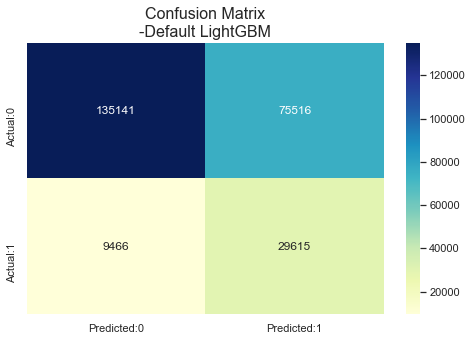

In [125]:
plot_report_and_matrix()

## easy enample classifer

In [128]:
from imblearn.ensemble import EasyEnsembleClassifier

base_estimator =LGBMClassifier(n_estimators=100)
eec = EasyEnsembleClassifier(n_estimators=10,
                             base_estimator=base_estimator)
eec.fit(X_train, y_train)
y_pred_eec = eec.predict(X_test)

In [129]:
y_pred_eec

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

              precision    recall  f1-score   support

           0       0.93      0.64      0.76    210657
           1       0.28      0.76      0.41     39081

    accuracy                           0.66    249738
   macro avg       0.61      0.70      0.59    249738
weighted avg       0.83      0.66      0.71    249738



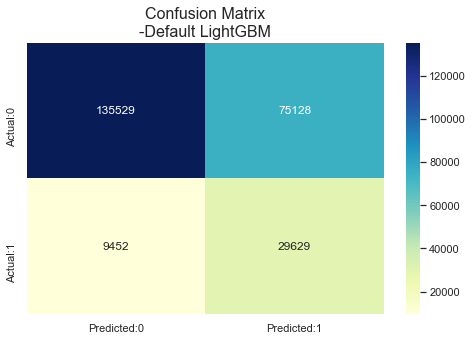

In [130]:
plot_report_and_matrix(y_pred=y_pred_eec)